# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.duplicated().sum()


0

In [8]:
df_reviews.describe()


,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Let's check the number of movies and reviews over years.

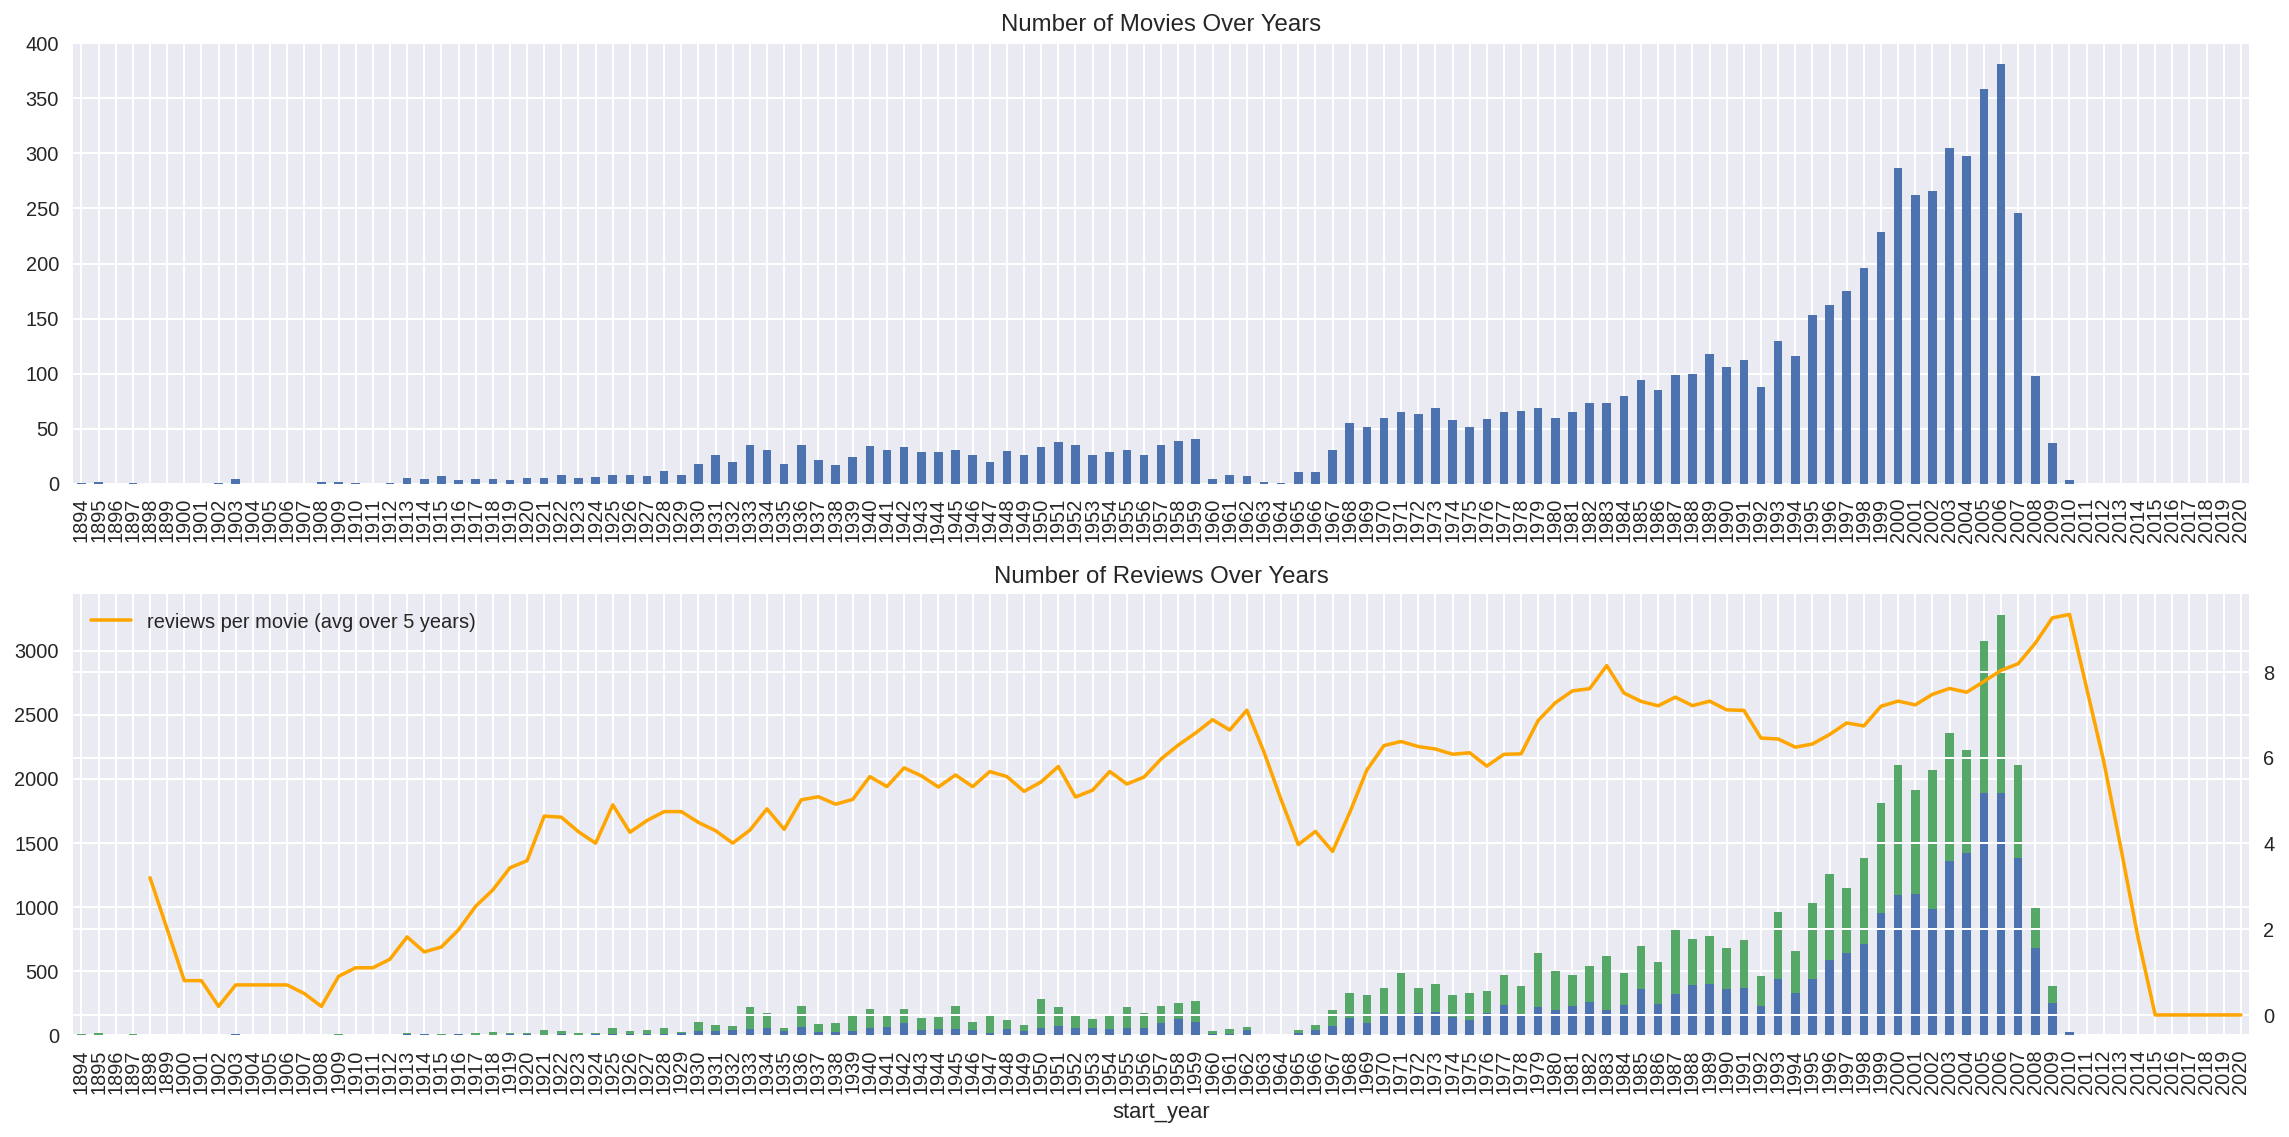

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We observed an overall increase in the number of movies released, with a peak in 2006, followed by a decrease thereafter. The number of reviews per movie also followed a similar pattern

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

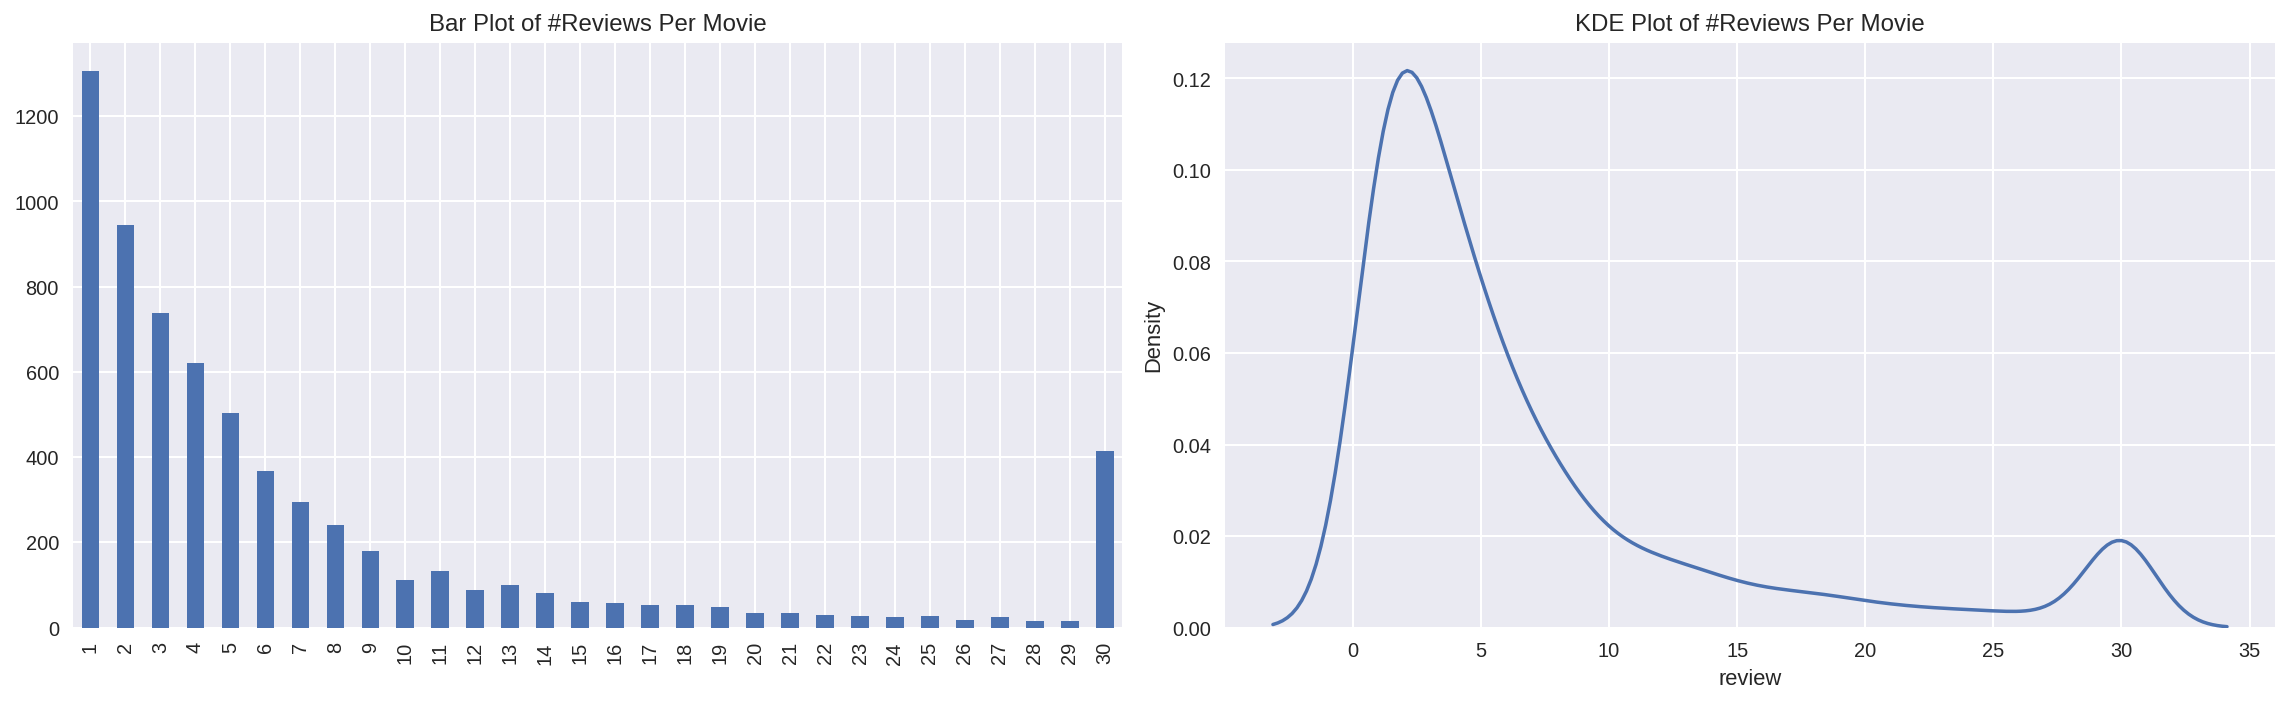

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We noticed that there are significantly more movies with only 1 review compared to those with higher numbers of reviews. The number of movies decreases steadily as the number of reviews increases, then there is a sudden increase at 30 reviews.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

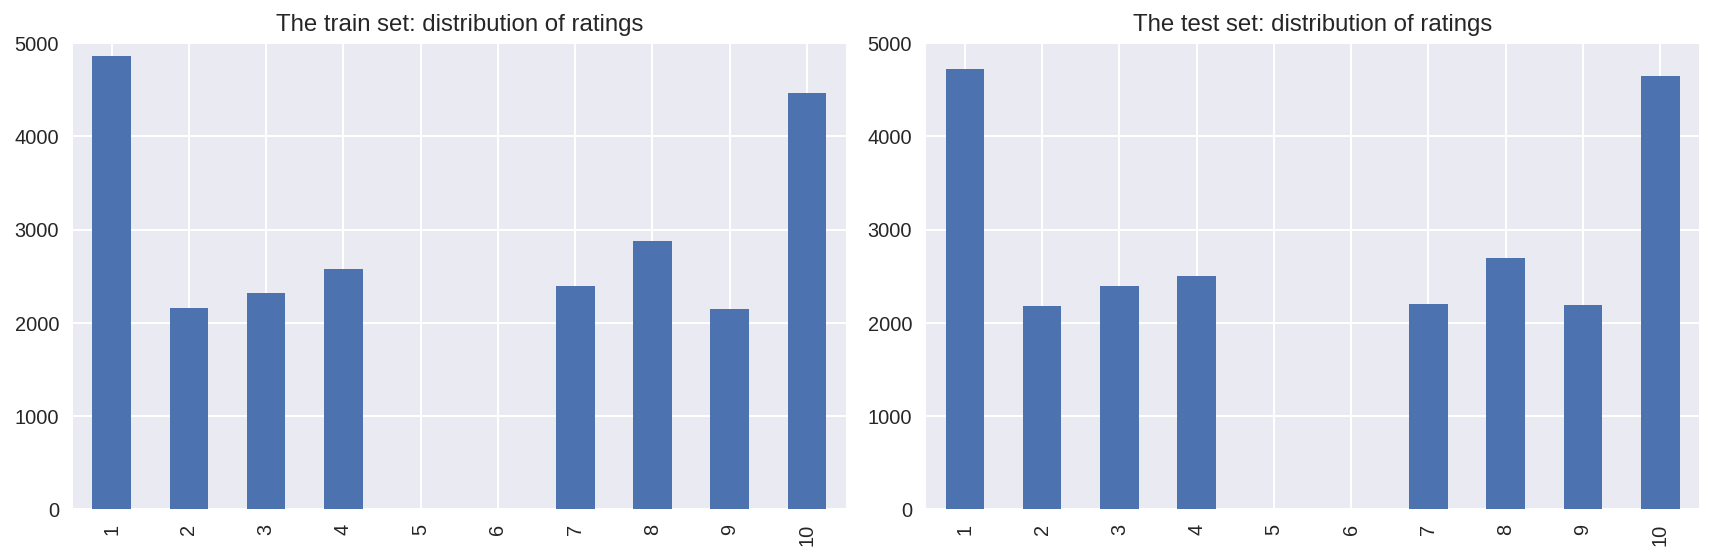

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

We observed that many reviews give a rating of 1, with the next highest number being those that give a rating of 10. There is not much variation in the number of reviews that give ratings of 2, 3, or 4 compared to those that give ratings of 7, 8, or 9. There are very few reviews that give a rating of 5 or 6

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


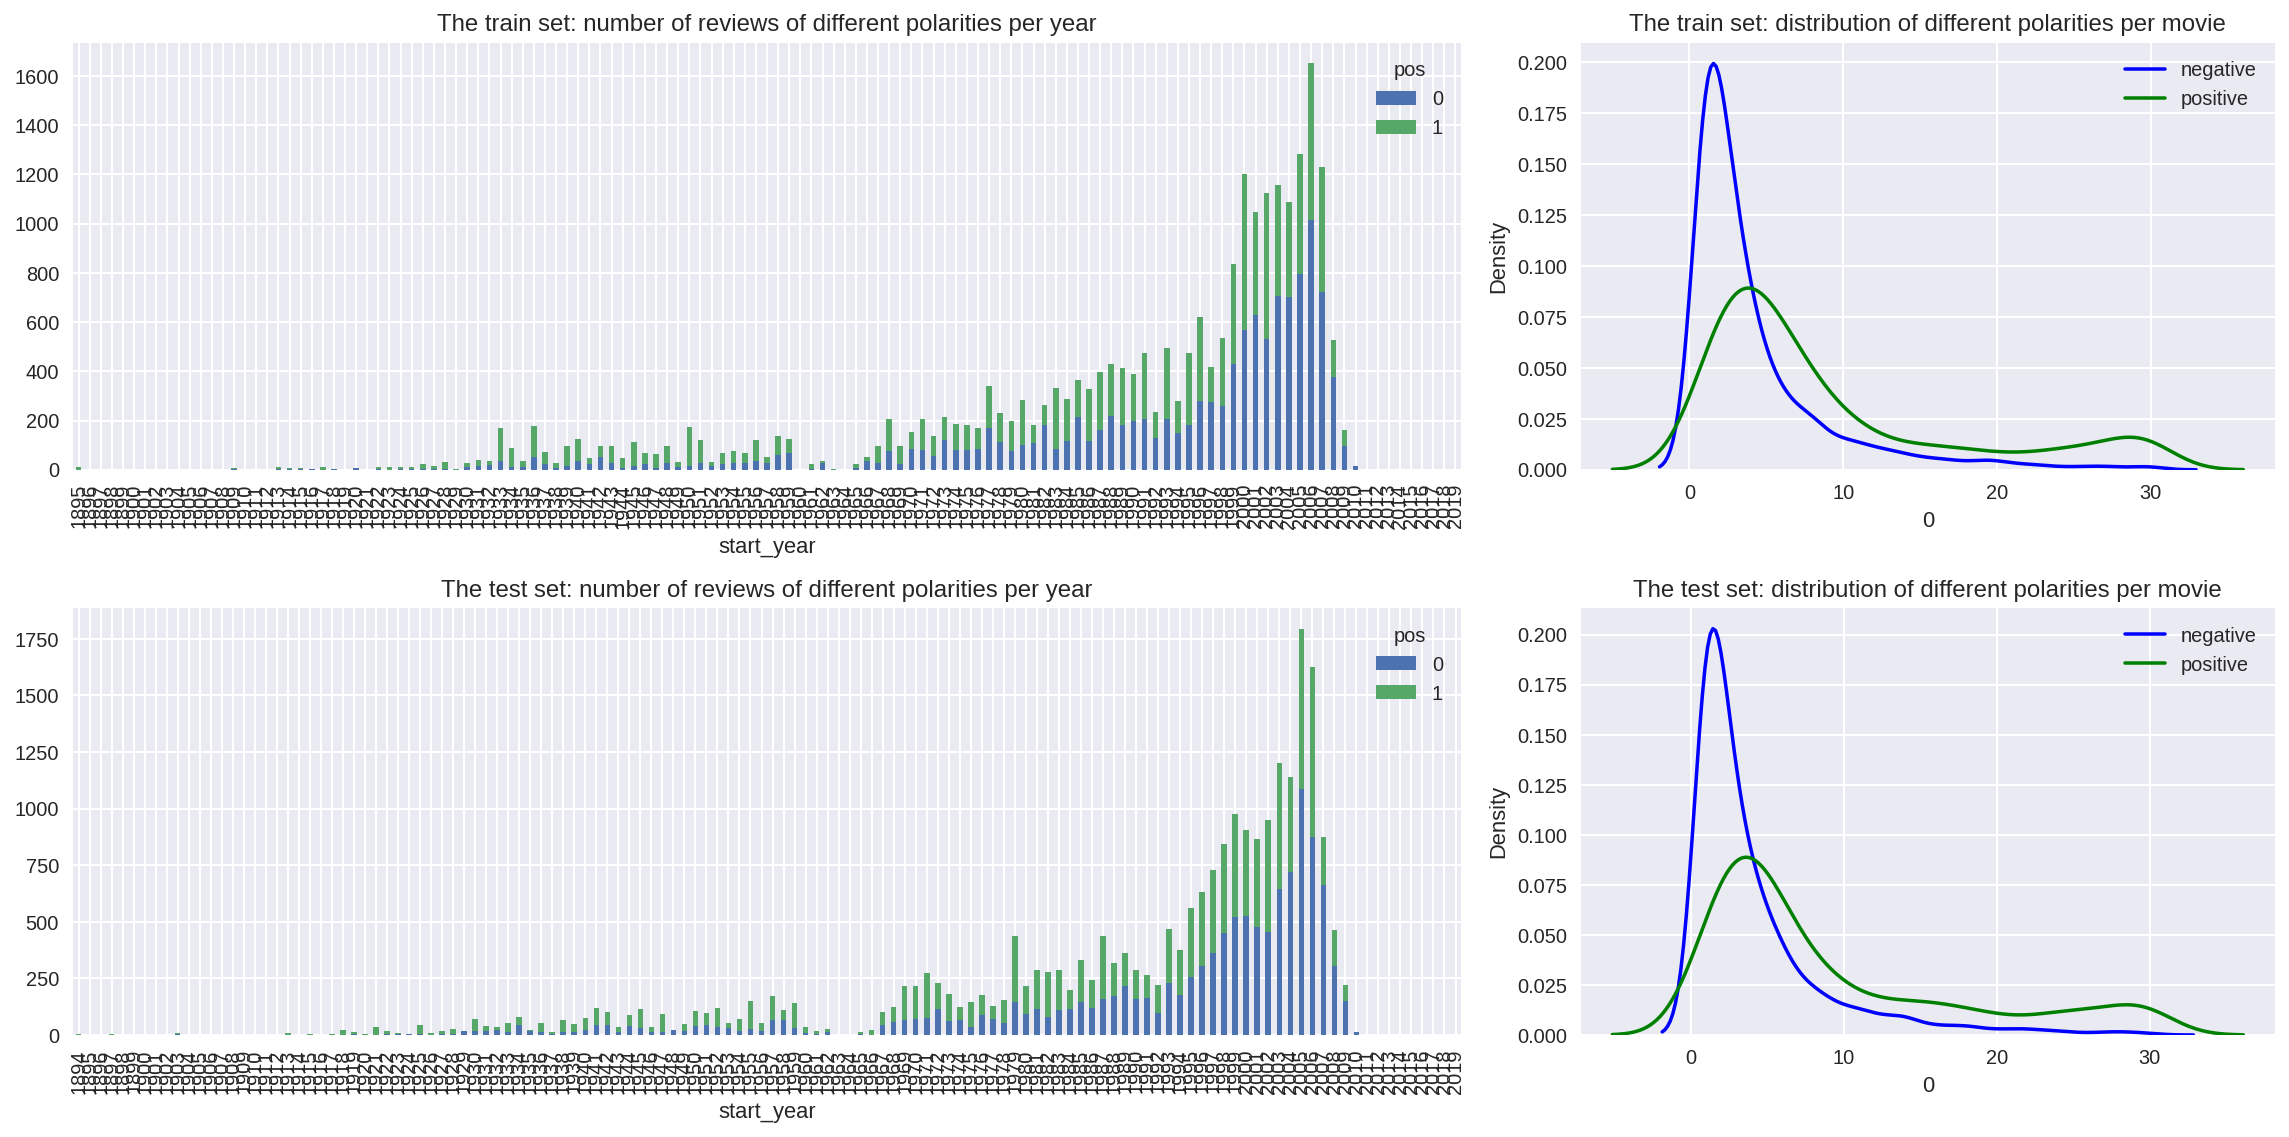

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We found that the number of positive and negative reviews is balanced and evenly distributed across years in both the training and test sets. It is expected that there are more reviews for newer movies, as they are likely to be viewed by more people compared to older movies.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
import string
import re

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.strip()
    return text

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text) # <put your code here>

In [18]:
print(df_reviews['review_norm'].sample(3))


12926    im the type of person who always goes  to horr...
5525     being a music student myself i thought a movie...
42072    i loved the first movie the second one was oka...
Name: review_norm, dtype: object


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_train = []
dummy_test = []

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


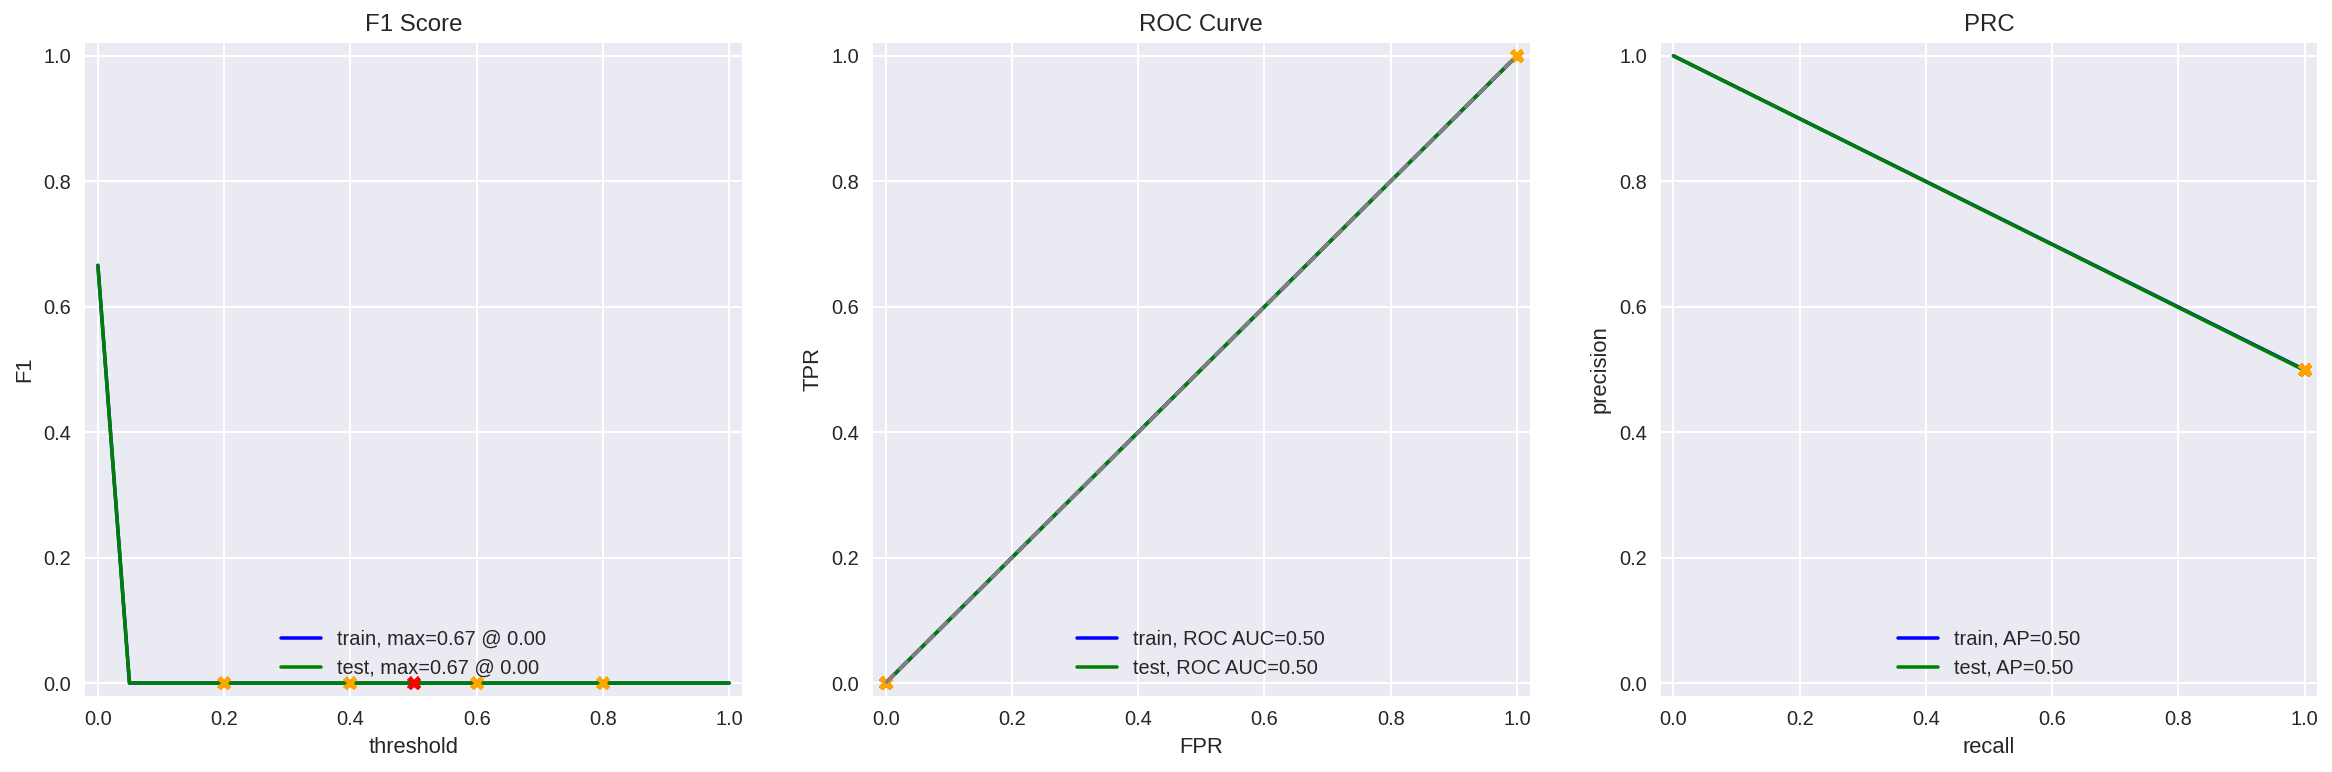

In [22]:
evaluate_model(dummy, df_reviews_train, train_target, df_reviews_test, test_target)


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [24]:
train_features = df_reviews_train['review_norm']
test_features  = df_reviews_test['review_norm']

In [25]:
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 
count_vect = CountVectorizer(stop_words=stop_words) 
train = train_features

tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words) 

train_features_1 = tfidf_vectorizer_2.fit_transform(train) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
test_features_1 = tfidf_vectorizer_2.transform(test_features) 


In [27]:
model_1 = LogisticRegression(solver='liblinear',random_state=12345)

model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


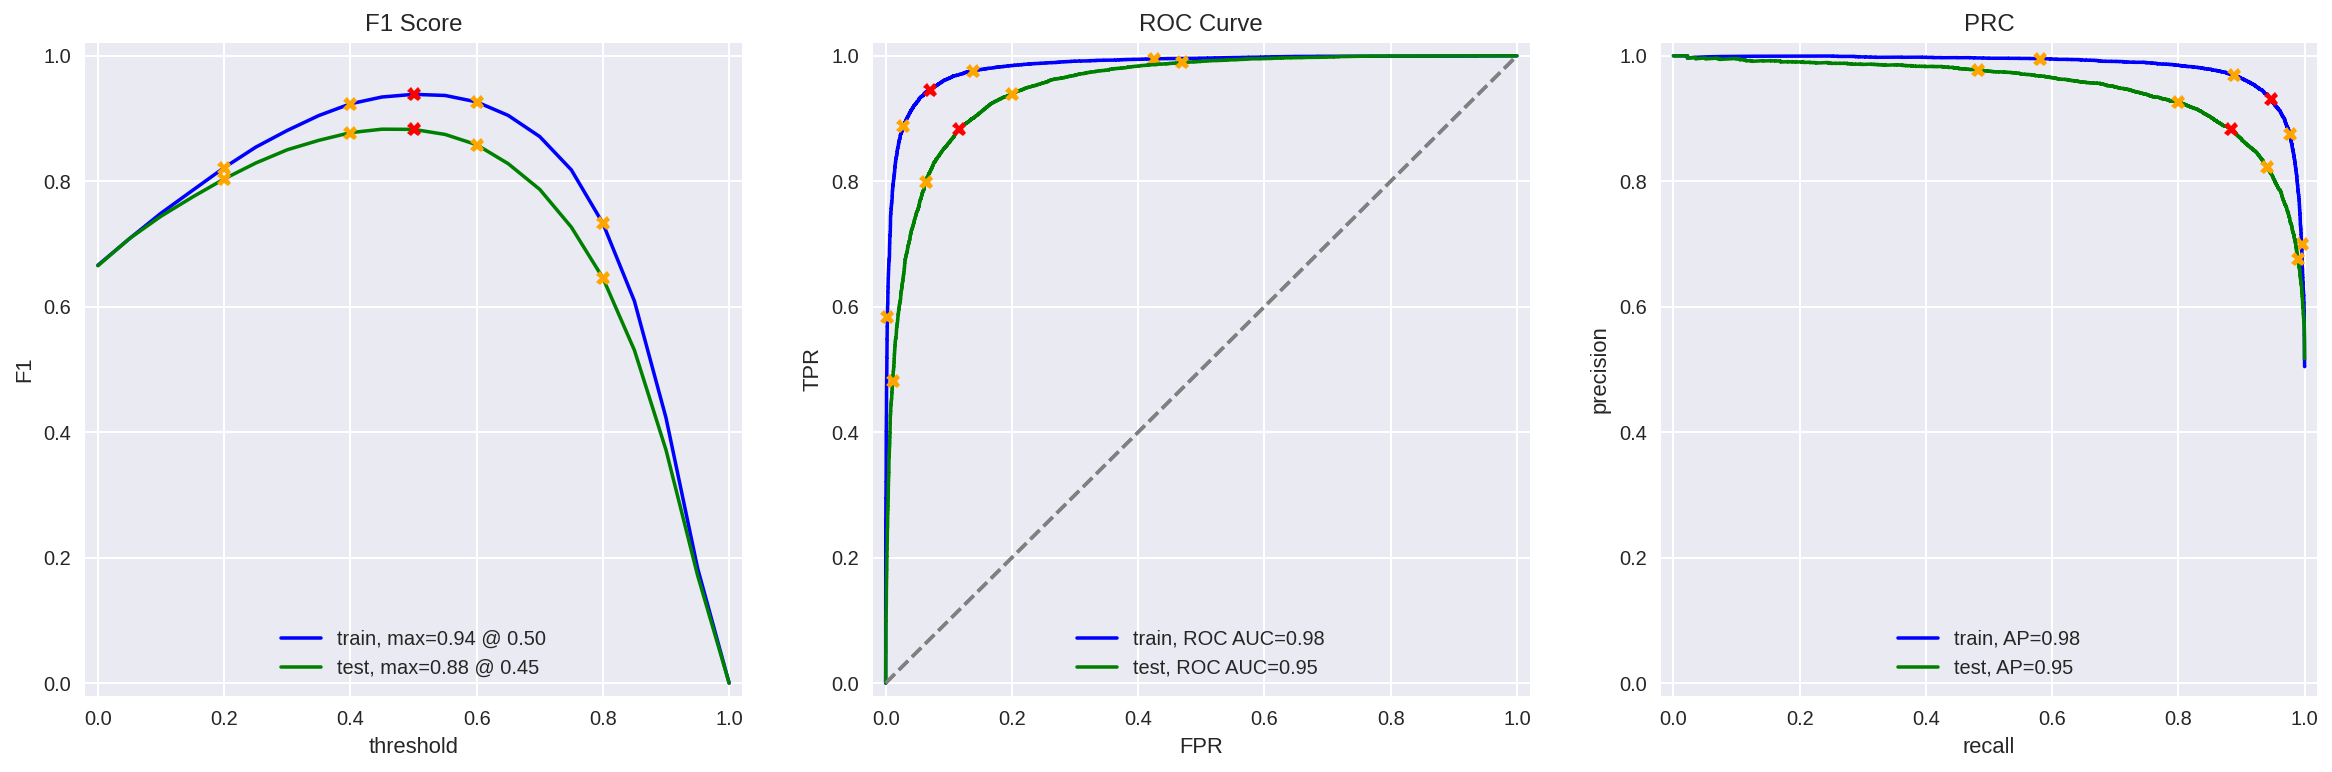

In [28]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [31]:
df_reviews_train['review_norm_spacy']=df_reviews_train['review_norm'].apply(lambda X: text_preprocessing(X))


In [32]:
df_reviews_test['review_norm_spacy']=df_reviews_test['review_norm'].apply(lambda X: text_preprocessing(X))


In [34]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

tfidf_vectorizer_3 = tfidf_vectorizer_3.fit(df_reviews_train['review_norm'])

train_features_2 = tfidf_vectorizer_3.transform(df_reviews_train['review_norm'])

test_features_2 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm'])

In [35]:
logregres = LogisticRegression(random_state = 12345, solver = 'liblinear')
logregres.fit(train_features_2, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

In [36]:
model_2=logregres


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


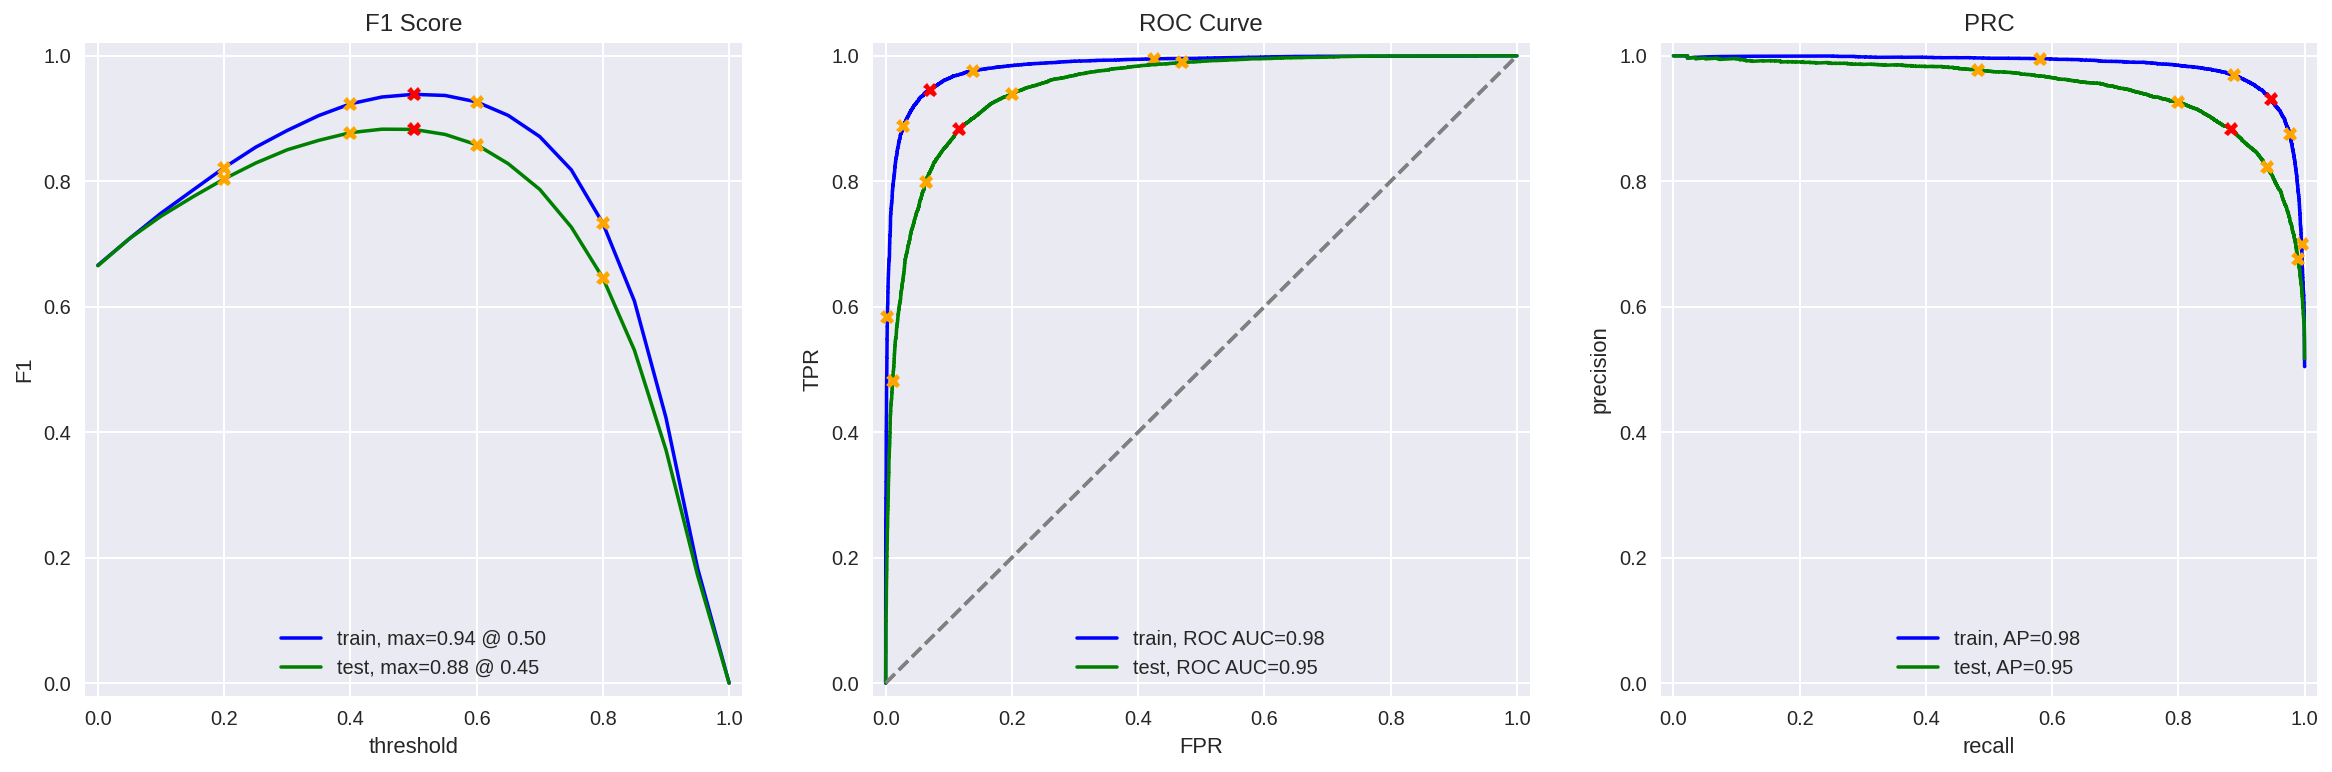

In [37]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [38]:
model=LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_2, train_target)
best_param=grid.best_params_

In [39]:
model_3=LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)
model_3.fit(train_features_2, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=30,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.90  0.85
F1         0.90  0.85
APS        0.96  0.92
ROC AUC    0.96  0.92


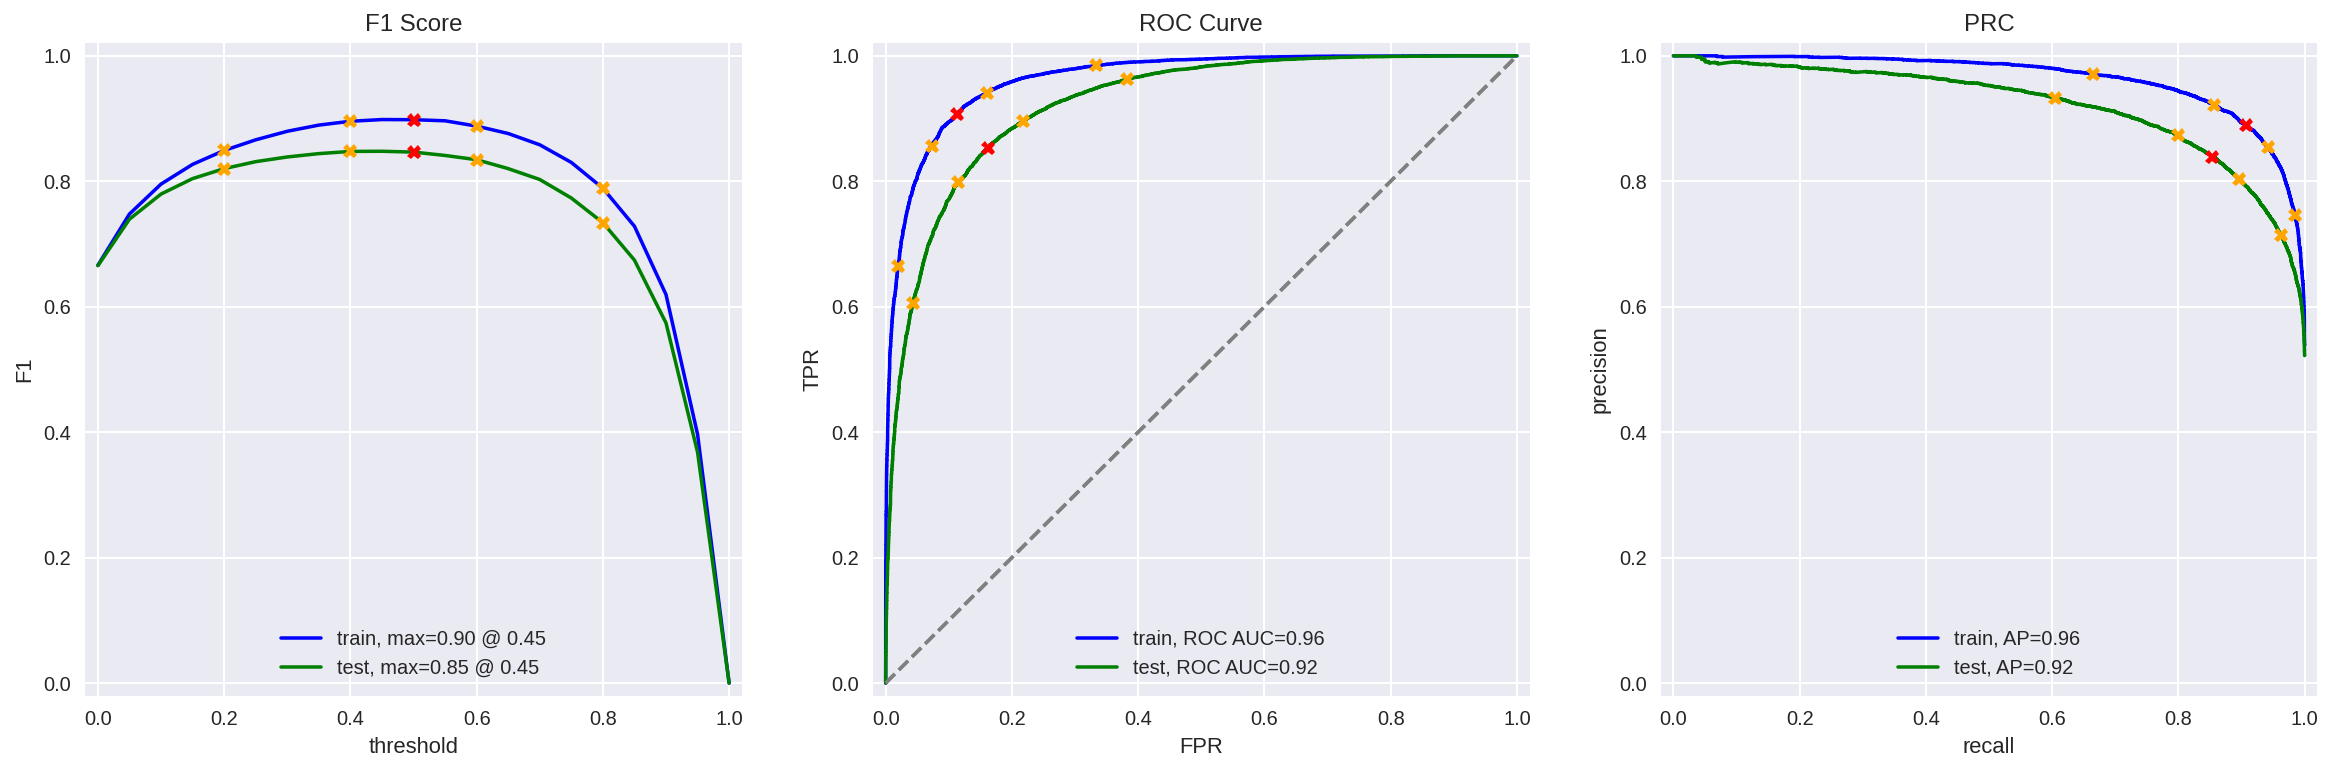

In [40]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)


## My Reviews

In [49]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [46]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.34:  i didn t expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [47]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.29:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.34:  i didn t expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [48]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.66:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.52:  i didn t expect the reboot to be so good writers really cared about the source material
0.66:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.21:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.75:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

Our analysis of the data showed that the number of movies released per year increased until 2006 and then decreased.



We also observed that movies with fewer reviews tended to have more positive reviews, and that there were more negative reviews per year compared to positive reviews


To predict whether a review would be positive or negative, we trained several models. The model that performed the best, as measured by the F1 score, was the Logistic Regression model using NLTK processing and the TF-IDF Vectorizer (F1 score of 0.88). Due to a lack of sufficient processing power, we were unable to train a BERT model.



